In [1]:
import pandas as pd
from os import walk

In [2]:
datasets_names = []
path_df = '../datasets/original_files/'
for (dirpath, dirnames, filenames) in walk(path_df):
    datasets_names.extend(filenames)
    break
datasets_names

['los_angeles-listings.csv.gz',
 'boston-listings.csv.gz',
 'new_york_city-listings.csv.gz']

In [3]:
dataFrame = False
first = True
for name in datasets_names:
    if(first):
        first = False
        dataFrame = pd.read_csv(path_df+name, compression='gzip')
        dataFrame.set_index('id', drop=False, inplace=True)
        print(name,'adding', len(dataFrame), 'rows')
    else:
        _tmpDf = pd.read_csv(path_df+name, compression='gzip')
        _tmpDf.set_index('id', drop=False, inplace=True)
        print(name,'adding', len(_tmpDf), 'rows')
        dataFrame = pd.concat([dataFrame, _tmpDf])
        del _tmpDf
print('total rows:', len(dataFrame))
dataFrame.head()

/home/santiago/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (61,62) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


los_angeles-listings.csv.gz adding 38481 rows
boston-listings.csv.gz adding 3799 rows


/home/santiago/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (61,62,94) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


new_york_city-listings.csv.gz adding 50796 rows
total rows: 93076


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
id,,,,,,,,,,,,,,,,,,,,,
109,109,https://www.airbnb.com/rooms/109,20200313233908,2020-03-14,Amazing bright elegant condo park front *UPGRA...,"*** Unit upgraded with new bamboo flooring, br...","*** Unit upgraded with new bamboo flooring, br...","*** Unit upgraded with new bamboo flooring, br...",none,NaN,...,f,f,strict_14_with_grace_period,t,f,1,1,0,0,0.02
344,344,https://www.airbnb.com/rooms/344,20200313233908,2020-03-14,Family perfect;Pool;Near Studios!,This home is perfect for families; aspiring ch...,"Cheerful & comfortable; near studios, amusemen...",This home is perfect for families; aspiring ch...,none,Quiet-yet-close to all the fun in LA! Hollywoo...,...,t,f,flexible,f,f,1,1,0,0,0.18
2708,2708,https://www.airbnb.com/rooms/2708,20200313233908,2020-03-14,Mirrored Mini-Suite with Fireplace - W. Hollywood,Our best memory foam pillows you'll ever sleep...,Flickering fireplace. Blendtec® Designer 625 ...,Our best memory foam pillows you'll ever sleep...,none,We are minutes away from the Mentor Language I...,...,t,f,strict_14_with_grace_period,f,f,2,0,2,0,0.33
2732,2732,https://www.airbnb.com/rooms/2732,20200313233908,2020-03-14,Zen Life at the Beach,NaN,This is a beautiful three story townhouse that...,This is a beautiful three story townhouse that...,none,"This is the best part of Santa Monica. Quiet, ...",...,f,f,strict_14_with_grace_period,f,f,2,1,1,0,0.20
2864,2864,https://www.airbnb.com/rooms/2864,20200313233908,2020-03-14,*Upscale Professional Home with Beautiful Studio*,Centrally located.... Furnished with 42 inch S...,The space is furnished with Thomasville furnit...,Centrally located.... Furnished with 42 inch S...,none,What makes the neighborhood unique is that the...,...,f,f,strict_14_with_grace_period,f,f,1,1,0,0,NaN


# Categorizando Columnas

In [69]:
text_cols = ["name","summary","space","description","neighborhood_overview","notes","transit","access",
             "interaction","house_rules","host_about"];
dummyable_cols = ["instant_bookable","is_business_travel_ready","cancellation_policy",
                  "require_guest_phone_verification","requires_license",
                  "require_guest_profile_picture","host_location","host_response_time",
                  "host_is_superhost","host_neighbourhood","host_has_profile_pic","host_identity_verified",
                  "has_availability","neighbourhood_cleansed","city","state","market",
                  "country_code","property_type","room_type","bed_type"];
dropeable_cols = ["id","listing_url","scrape_id","last_scraped","thumbnail_url","medium_url",
                  "picture_url","xl_picture_url","host_url","host_name","host_id","host_thumbnail_url",
                 "host_picture_url","host_total_listings_count","calendar_updated","calendar_last_scraped",
                  "neighbourhood","neighbourhood_group_cleansed","zipcode","smart_location","country",
                 "experiences_offered"];
continuos_cols = ["reviews_per_month","host_response_rate","host_acceptance_rate",
                  "review_scores_communication","review_scores_location","review_scores_value",
                  "number_of_reviews_ltm","review_scores_rating","review_scores_cleanliness",
                  "review_scores_checkin","availability_30","availability_60","availability_90","availability_365",
                 "review_scores_accuracy","minimum_nights","maximum_nights","minimum_minimum_nights",
                  "maximum_minimum_nights","minimum_maximum_nights","maximum_maximum_nights",
                  "minimum_nights_avg_ntm","maximum_nights_avg_ntm",
                  "calculated_host_listings_count","calculated_host_listings_count_entire_homes",
                  "calculated_host_listings_count_private_rooms","calculated_host_listings_count_shared_rooms",
                  "host_listings_count","number_of_reviews",
                  "accommodates","bathrooms","bedrooms","beds","guests_included",
                  ]
date_cols = ["host_since","first_review","last_review"]
explotable_cols = ["street","host_verifications","jurisdiction_names","amenities"]
geo_cols = ["latitude","longitude","is_location_exact"]

target_col = ["price","weekly_price","monthly_price","security_deposit","cleaning_fee","extra_people"]
#license ?

In [36]:
#dataFrame.drop(text_cols,axis=1,inplace=True);
#dataFrame.drop(dummyable_cols,axis=1,inplace=True);
#dataFrame.drop(dropeable_cols,axis=1,inplace=True);
#dataFrame.drop(continuos_cols,axis=1,inplace=True);
#dataFrame.drop(date_cols,axis=1,inplace=True);
#dataFrame.drop(explotable_cols,axis=1,inplace=True);
#dataFrame.drop(geo_cols,axis=1,inplace=True);

#dataFrame.drop(target_col,axis=1,inplace=True);

# Ejemplos de las columnas categorizadas

In [37]:
#Columnas detectadas como texto
dataFrame.sample(5).loc[:,text_cols].T

id,27663483,26076732,29486729,6143225,37420358
name,Lux Apartment across Hudson River - city view ⭐,Brooklyn 28+day Refuge - Private Bedroom w/lounge,"Charming Spanish Condo, Prime Studio City",4 BD Laurel Canyon Hollywood Hills Home,Cozy Rockaway Sailboat Retreat
summary,Perfectly located 3 blocks from Times Square |...,Stay for a while in the heart of Beautiful His...,(choose 31 days to save on the LA short term t...,HSR (Phone number hidden by Airbnb) LA City Sh...,"Step aboard Eugene’s Dream, a cozy sailboat re..."
space,A spacious apartment with city view in a luxur...,NaN,This is a great space to relax in los Angeles ...,The Space This remodeled 1923 former hunting c...,The Q22 bus awaits outside the gates to whisk ...
description,Perfectly located 3 blocks from Times Square |...,Stay for a while in the heart of Beautiful His...,(choose 31 days to save on the LA short term t...,HSR (Phone number hidden by Airbnb) LA City Sh...,"Step aboard Eugene’s Dream, a cozy sailboat re..."
neighborhood_overview,"A luxury vibe, you will get to be around New Y...",NaN,The unit is a short walk to Ralph's Grocery St...,Peace and quiet in a bustling metropolis! You ...,NaN
notes,NaN,NaN,NaN,Trash cans need to be put out on Wednesdays an...,NaN
transit,Port Authority Subway is 5 min walk Local and ...,NaN,Easy walk to the Red Line train and also use t...,Getting Around We are off Mulholland Drive wit...,NaN
access,Doorman,Long term 28+days summer time guests will have...,NaN,Access through the lower garden gate. You have...,NaN
interaction,You stay across the street from UCB theatre an...,NaN,NaN,Our house manager lives nearby and will welcom...,NaN
house_rules,"Late check in charges may apply, please check ...",- Please water house plants.,NaN,Thank you in advance for respecting our house ...,NaN


In [38]:
#Columnas detectadas como candidatas para hacer Dummies
dataFrame.sample(5).loc[:,dummyable_cols].T

id,16543714,26063060,37590421,9981869,4930951
instant_bookable,t,t,f,f,f
is_business_travel_ready,f,f,f,f,f
cancellation_policy,moderate,moderate,strict_14_with_grace_period,flexible,moderate
require_guest_phone_verification,f,f,f,f,f
requires_license,t,t,f,t,f
require_guest_profile_picture,f,f,f,f,f
host_location,"Los Angeles, California, United States","Los Angeles, California, United States",US,"Los Angeles, California, United States","New York, New York, United States"
host_response_time,within an hour,within an hour,within an hour,NaN,NaN
host_is_superhost,t,t,f,f,f
host_neighbourhood,NaN,Venice,Lower East Side,Palms,Greenwich Village


In [39]:
#Columnas a ser dropeadas directamente
dataFrame.sample(5).loc[:,dropeable_cols].T

id,8033609,35877016,19356281,36033353,18734125
id,8033609,35877016,19356281,36033353,18734125
listing_url,https://www.airbnb.com/rooms/8033609,https://www.airbnb.com/rooms/35877016,https://www.airbnb.com/rooms/19356281,https://www.airbnb.com/rooms/36033353,https://www.airbnb.com/rooms/18734125
scrape_id,20200313233810,20200313233810,20200313233810,20200313233908,20200313233810
last_scraped,2020-03-14,2020-03-14,2020-03-14,2020-03-14,2020-03-14
thumbnail_url,NaN,NaN,NaN,NaN,NaN
medium_url,NaN,NaN,NaN,NaN,NaN
picture_url,https://a0.muscache.com/im/pictures/c4fd2915-d...,https://a0.muscache.com/im/pictures/9fd34cd0-7...,https://a0.muscache.com/im/pictures/cda335cb-e...,https://a0.muscache.com/im/pictures/c918a084-8...,https://a0.muscache.com/im/pictures/70c65096-e...
xl_picture_url,NaN,NaN,NaN,NaN,NaN
host_url,https://www.airbnb.com/users/show/33213436,https://www.airbnb.com/users/show/6489574,https://www.airbnb.com/users/show/11495231,https://www.airbnb.com/users/show/4254885,https://www.airbnb.com/users/show/81066021
host_name,Alec,Wilson,Kelly,Angela,Javerick


In [40]:
#Columnas detectadas como valores continuos, para reescalar
dataFrame.sample(5).loc[:,continuos_cols].T

id,9747682,9345131,33984685,42155101,10377445
reviews_per_month,0.86,NaN,NaN,NaN,NaN
host_response_rate,NaN,NaN,100%,100%,NaN
host_acceptance_rate,85%,NaN,78%,100%,NaN
review_scores_communication,10,NaN,NaN,NaN,NaN
review_scores_location,10,NaN,NaN,NaN,NaN
review_scores_value,9,NaN,NaN,NaN,NaN
number_of_reviews_ltm,9,0,0,0,0
review_scores_rating,96,NaN,NaN,NaN,NaN
review_scores_cleanliness,8,NaN,NaN,NaN,NaN
review_scores_checkin,10,NaN,NaN,NaN,NaN


In [41]:
#Columnas detectadas como fecha 
dataFrame.sample(5).loc[:,date_cols].T

id,13157343,6971750,40473361,12328939,27359897
host_since,2016-05-23,2014-12-26,2013-01-10,2016-04-10,2015-10-30
first_review,2016-07-17,2015-10-03,NaN,2016-05-22,2018-08-02
last_review,2019-01-02,2018-09-30,NaN,2019-10-12,2020-01-05


In [42]:
#Columnas que habria que trabajar para separarles los datos
dataFrame.sample(5).loc[:,explotable_cols].T

id,20195539,41510861,8014087,7473909,31381103
street,"New York, NY, United States","Lynwood, CA, United States","New York, NY, United States","Brooklyn, NY, United States","Queens, NY, United States"
host_verifications,"['email', 'phone', 'reviews', 'jumio', 'offlin...","['email', 'phone']","['email', 'phone', 'facebook', 'reviews', 'jum...","['email', 'phone', 'reviews', 'jumio', 'offlin...","['email', 'phone', 'reviews', 'jumio', 'offlin..."
jurisdiction_names,NaN,NaN,NaN,NaN,NaN
amenities,"{TV,Wifi,""Air conditioning"",Kitchen,""Free park...","{TV,Wifi,""Air conditioning"",Kitchen,""Smoke det...","{TV,""Cable TV"",Wifi,""Air conditioning"",Kitchen...","{Wifi,""Air conditioning"",Kitchen,""Free street ...","{Wifi,Kitchen,""Free street parking"",Heating,""S..."


In [33]:
#Columnas detectadas como informacion de geolocalizacion
dataFrame.sample(5).loc[:,geo_cols].T

id,8554790,40842631,20136121,40572768,41717488
latitude,33.9645,34.1646,40.5729,34.0964,34.0586
longitude,-118.432,-118.368,-74.0961,-118.348,-118.384
is_location_exact,t,t,t,t,t


In [34]:
#Columnas detectadas como que pueden filtrar informacion del target
dataFrame.sample(5).loc[:,target_col].T

id,26595733,26655705,38748724,21263008,25355220
price,$76.00,$102.00,$63.00,"$1,150.00",$142.00
weekly_price,NaN,NaN,NaN,NaN,NaN
monthly_price,NaN,NaN,NaN,NaN,NaN
security_deposit,NaN,"$1,000.00",NaN,"$1,000.00",$0.00
cleaning_fee,$30.00,$85.00,$30.00,$500.00,$200.00
extra_people,$25.00,$35.00,$25.00,$50.00,$0.00


# Test de modelado solo con Dummies

In [161]:
# drop outliers
dataFrame["price"]=dataFrame["price"].str.replace('$', '').str.replace(',', '').astype(float)

Q1 = dataFrame["price"].quantile(0.02)
Q3 = dataFrame["price"].quantile(0.98)

dataFrame.drop(dataFrame[dataFrame["price"] > Q3].index,axis=0,inplace=True);
dataFrame.drop(dataFrame[dataFrame["price"] < Q1].index,axis=0,inplace=True);

dataFrame["price"].describe()

count    89700.000000
mean       144.573244
std        116.798060
min         30.000000
25%         70.000000
50%        110.000000
75%        179.000000
max        899.000000
Name: price, dtype: float64

In [162]:
import numpy as np

# generamos las dummies y limpiamos el vector target
X = pd.get_dummies(dataFrame[dummyable_cols].astype(str), drop_first=True).reset_index(drop=True)
y = np.log(dataFrame["price"].reset_index(drop=True));
X.shape

(89700, 4421)

In [168]:
y.describe()

count    89700.000000
mean         4.737312
std          0.665061
min          3.401197
25%          4.248495
50%          4.700480
75%          5.187386
max          6.801283
Name: price, dtype: float64

In [163]:
# separamos entrenamiento y test
from sklearn.model_selection import train_test_split
train_data, val_data, train_targets, val_targets = train_test_split(X, y, test_size=0.2, random_state=42)

train_data.shape

(71760, 4421)

In [164]:
train_targets

12163    6.109248
19892    5.010635
10685    4.595120
22094    4.382027
47722    5.298317
           ...   
6265     6.163315
54886    3.496508
76820    4.234107
860      5.298317
15795    5.298317
Name: price, Length: 71760, dtype: float64

In [165]:
from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers

model = Sequential()
model.add(Dense(50, activation='relu', input_shape=(train_data.shape[1],),kernel_regularizer=regularizers.l1(0.001)))
model.add(Dense(50, activation='relu',kernel_regularizer=regularizers.l1(0.001)))
model.add(Dense(50, activation='relu',kernel_regularizer=regularizers.l1(0.001)))
model.add(Dense(1,kernel_regularizer=regularizers.l1(0.001)))
model.compile(optimizer='rmsprop', loss='mean_squared_error', metrics=['mae'])
model.fit(train_data, train_targets,epochs=5, batch_size=500, verbose=1)

Using TensorFlow backend.


Epoch 1/5
71760/71760 [==============================] - 17s 232us/step - loss: 3.0584 - mae: 0.8857
Epoch 2/5
71760/71760 [==============================] - 16s 221us/step - loss: 0.6432 - mae: 0.3964
Epoch 3/5
71760/71760 [==============================] - 16s 222us/step - loss: 0.5747 - mae: 0.3884
Epoch 4/5
71760/71760 [==============================] - 19s 265us/step - loss: 0.5560 - mae: 0.3844
Epoch 5/5
71760/71760 [==============================] - 19s 270us/step - loss: 0.5398 - mae: 0.3805


In [166]:
model.evaluate(val_data, val_targets, verbose=0)

[0.5089047969052093, 0.36275073885917664]

# Inspeccionamos los valores continuos

In [77]:
#revisamos una pequeña muestra de los datos
dataFrame.sample(5).loc[:,continuos_cols].T

id,41114132,39359116,39951411,7956149,7773026
reviews_per_month,NaN,NaN,NaN,NaN,0.05
host_response_rate,100%,NaN,NaN,NaN,100%
host_acceptance_rate,NaN,100%,NaN,NaN,93%
review_scores_communication,NaN,NaN,NaN,NaN,9
review_scores_location,NaN,NaN,NaN,NaN,10
review_scores_value,NaN,NaN,NaN,NaN,10
number_of_reviews_ltm,0,0,0,0,1
review_scores_rating,NaN,NaN,NaN,NaN,100
review_scores_cleanliness,NaN,NaN,NaN,NaN,9
review_scores_checkin,NaN,NaN,NaN,NaN,10


* 1ro lo obvio -> son todos valores continuos.
* 2do -> Se puede apreciar presencia de valores null.
* 3ro -> Se vé que hay diferentes escalas de datos. Será conveniente reescalar y normalizar.
* 4to -> Quizas sea favorable puede aplicar transformaciones para favorecer la predictibilidad


In [78]:
dataFrame.loc[:,continuos_cols].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93076 entries, 109 to 42892717
Data columns (total 34 columns):
reviews_per_month                               74169 non-null float64
host_response_rate                              65793 non-null object
host_acceptance_rate                            73098 non-null object
review_scores_communication                     72635 non-null float64
review_scores_location                          72595 non-null float64
review_scores_value                             72592 non-null float64
number_of_reviews_ltm                           93076 non-null int64
review_scores_rating                            72707 non-null float64
review_scores_cleanliness                       72645 non-null float64
review_scores_checkin                           72603 non-null float64
availability_30                                 93076 non-null int64
availability_60                                 93076 non-null int64
availability_90                           

* Acá se detectan 2 columnas que vienen con tipo de dato Object

In [68]:
# Analisis clasico
dataFrame.loc[:,continuos_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
reviews_per_month,74169.0,1.538199e+00,1.798052e+00,0.01,0.24,0.86,2.31,6.636000e+01
review_scores_communication,72635.0,9.730433e+00,7.906184e-01,2.00,10.00,10.00,10.00,1.000000e+01
review_scores_location,72595.0,9.643309e+00,7.372899e-01,2.00,9.00,10.00,10.00,1.000000e+01
review_scores_value,72592.0,9.399796e+00,9.362092e-01,2.00,9.00,10.00,10.00,1.000000e+01
number_of_reviews_ltm,93076.0,1.118341e+01,1.874695e+01,0.00,0.00,2.00,15.00,7.300000e+02
review_scores_rating,72707.0,9.403910e+01,8.875381e+00,20.00,92.00,97.00,100.00,1.000000e+02
review_scores_cleanliness,72645.0,9.351229e+00,1.042774e+00,2.00,9.00,10.00,10.00,1.000000e+01
review_scores_checkin,72603.0,9.740796e+00,7.576959e-01,2.00,10.00,10.00,10.00,1.000000e+01
availability_30,93076.0,1.243204e+01,1.219245e+01,0.00,0.00,11.00,25.00,3.000000e+01
availability_60,93076.0,2.639911e+01,2.415514e+01,0.00,0.00,26.00,52.00,6.000000e+01


* se detectan varios campos con valores null, vamos a usar esto para intentar rellenarlo cuando sea posible

# Graficamos para ver interelacion

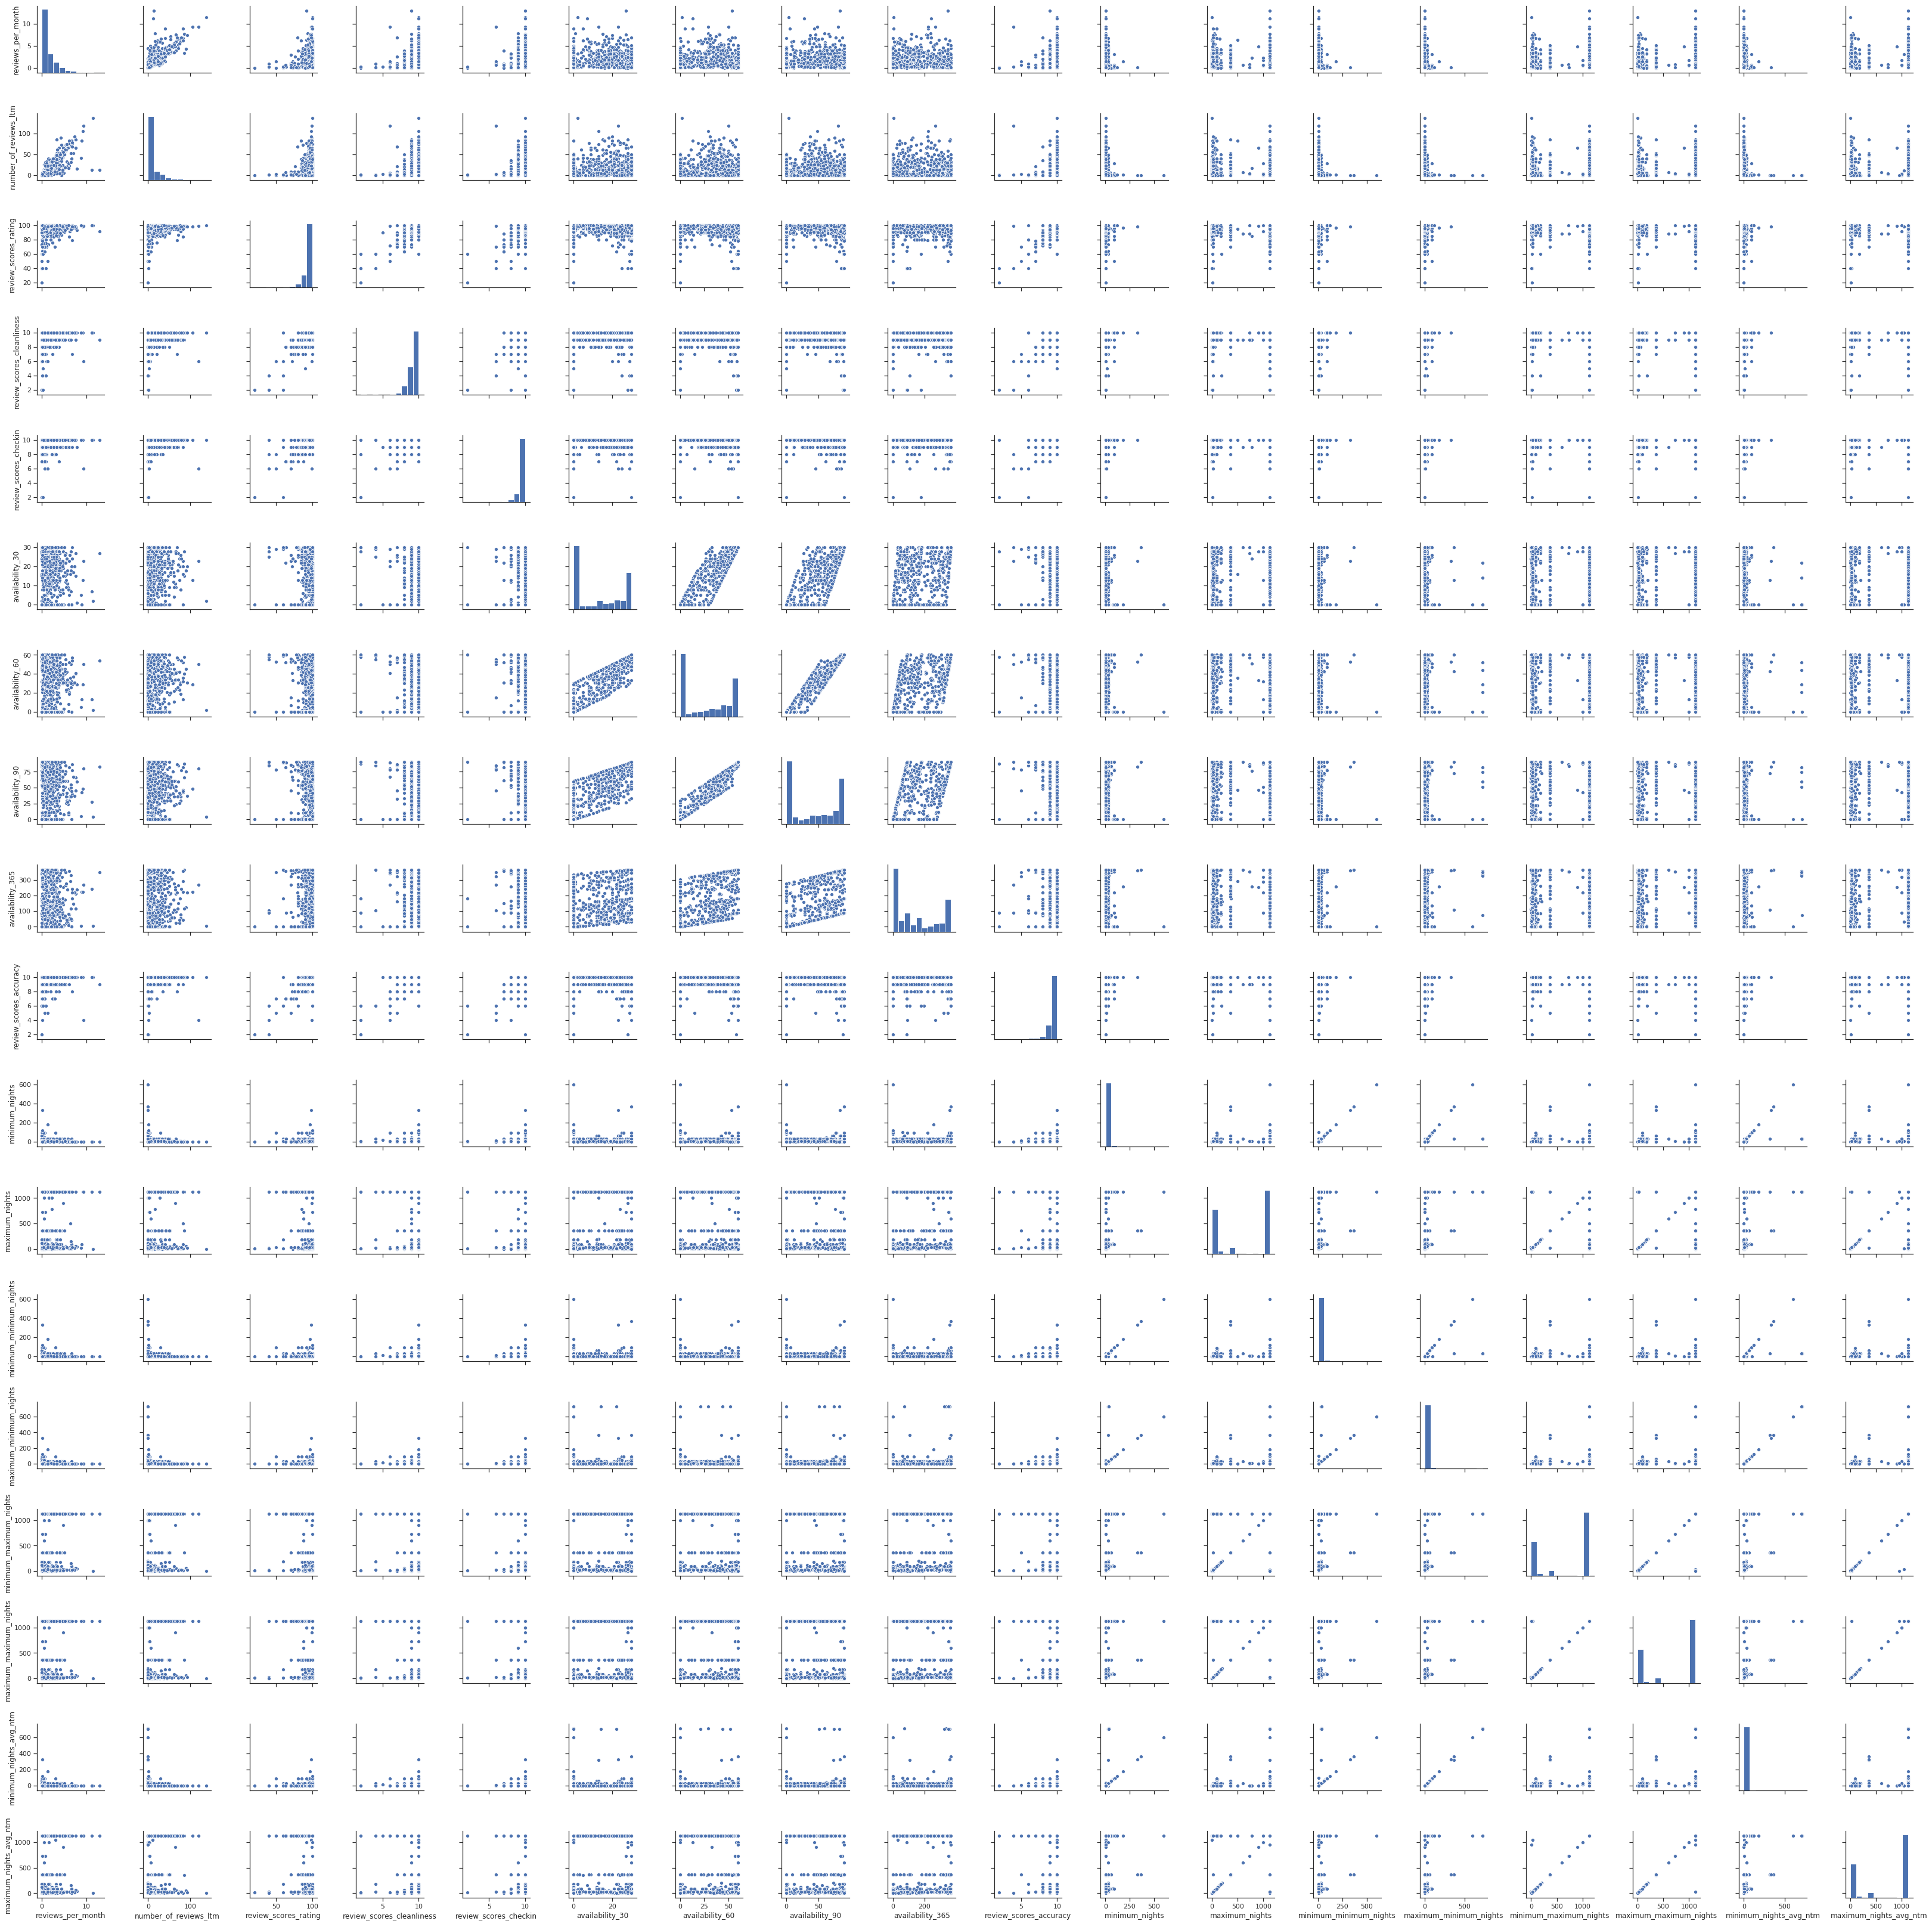

In [24]:
import seaborn as sns; sns.set(style="ticks", color_codes=True)
sns.pairplot(dataFrame.sample(1000).loc[:,continuos_cols])

# Creamos los pasos del pipeline

In [150]:
from sklearn.base import BaseEstimator, TransformerMixin

#Esta clase simplemente filtra las columnas que se le indica en el constructor
class FeatureSelector( BaseEstimator, TransformerMixin ):
    #Class Constructor 
    def __init__( self, feature_names ):
        self._feature_names = feature_names 
    
    #Return self nothing else to do here    
    def fit( self, X, y = None ):
        return self 
    
    #Method that describes what we need this transformer to do
    def transform( self, X, y = None ):
        return X[ self._feature_names ] 

In [156]:
import numpy as np

class NumericalImputer(BaseEstimator, TransformerMixin):
    def __init__( self, default_strategy = "median"):
        self._default_strategy = default_strategy
        self._default_values = {}
        
    def fit( self, X, y = None ):
        X.host_response_rate = X.host_response_rate.str.replace('%', '').astype(float)
        X.host_acceptance_rate = X.host_acceptance_rate.str.replace('%', '').astype(float)
        
        #Si hay valores infinitos los convertimos en NaN
        X = X.replace( [ np.inf, -np.inf ], np.nan )
        
        for col in X.columns:
            if col=='number_of_reviews_ltm':
                default_value=0;
            elif col=='number_of_reviews':
                default_value=0;
            elif col=='host_listings_count':
                default_value=1;
            elif self._default_strategy=='median':
                default_value=np.median(X[col].dropna())
            elif self._default_strategy=='mode':
                default_value=np.mode(X[col].dropna())
            elif self._default_strategy=='mean':
                default_value=np.mean(X[col].dropna())
            else:
                default_value=np.median(X[col].dropna())
            self._default_values[col]=default_value

        return self 
    
    def transform(self, X, y = None):
        X.host_response_rate = X.host_response_rate.astype(str).str.replace('%', '').astype(float)
        X.host_acceptance_rate = X.host_acceptance_rate.astype(str).str.replace('%', '').astype(float)
        
        for col in X.columns:
            #Si hay valores infinitos los convertimos en NaN
            X[col] = X[col].replace( [ np.inf, -np.inf ], np.nan)
            X[col].fillna(self._default_values[col],inplace=True)
        return X

class NumericalTransformer(BaseEstimator, TransformerMixin):
    def __init__( self, log_transform = True, bath_per_bed = True, bath_per_bedroom = True ):
        self._bath_per_bed = bath_per_bed
        self._bath_per_bedroom = bath_per_bedroom
        self._log_transform = log_transform
        
    def fit( self, X, y = None ):
        return self 
    
    def transform(self, X, y = None):
        if self._bath_per_bedroom:
            X.loc['bath_per_bedroom'] = X['bathrooms'] / X['bedrooms']
        if self._bath_per_bed:
            X.loc['bath_per_bed'] = X['bathrooms'] / X['beds']
        if self._log_transform:
            for col in X.columns:
                X[col] = X[col];
                #X[col] = np.log(X[col])
        
        #pd.cut(df.Age,bins=[0,2,17,65,99],labels=['Toddler/Baby','Child','Adult','Elderly'])
        
        #Retornamos un array de Numpy
        return X

# Generamos los pipelines

In [157]:
from sklearn.pipeline import FeatureUnion, Pipeline 
from sklearn.preprocessing import OneHotEncoder, StandardScaler

#Definimos los pasos para el pipeline de Dummies
#categorical_pipeline = Pipeline( steps = [ ( 'cat_selector', FeatureSelector(categorical_features) ),
#                                  ( 'cat_transformer', CategoricalTransformer() ), 
#                                  ( 'one_hot_encoder', OneHotEncoder( sparse = False ) ) ] )
    
#Definimos los pasos para el pipeline Numerico
numerical_pipeline = Pipeline( steps = [ ( 'num_selector', FeatureSelector(continuos_cols) ),
                                  ( 'num_imputer', NumericalImputer(default_strategy = 'median') ),
                                  ( 'num_transformer', NumericalTransformer() ),
                                  ( 'std_scaler', StandardScaler() ) 
                                       ] )

#Combinamos los diferentes pipelines en uno gran pipeline horizontal usando FeatureUnion
full_pipeline = FeatureUnion( transformer_list = [ 
#                                                  ( 'categorical_pipeline', categorical_pipeline ), 
                                                  ( 'numerical_pipeline', numerical_pipeline ) ] )

In [158]:
full_pipeline.fit(dataFrame);

/home/santiago/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/home/santiago/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/santiago/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-

In [159]:
result=pd.DataFrame( full_pipeline.transform(dataFrame))

/home/santiago/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/home/santiago/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/santiago/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-

In [160]:
result

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
0,-0.847885,0.303085,-4.021330,-2.530299,0.416664,-1.774302,-0.596549,-1.849935,0.527691,-5.603557,...,-0.199319,-0.245095,-0.104375,-0.161026,-0.493605,1.205848,0.956071,0.743086,0.906485,0.866986
1,-0.749610,-1.955074,-3.009238,0.297428,0.416664,0.542189,-0.489864,0.291329,0.527691,0.298325,...,-0.199319,-0.245095,-0.104375,-0.161026,-0.387819,1.205848,-0.386494,1.797390,0.906485,2.882293
2,-0.657478,0.303085,0.303063,0.297428,0.416664,0.542189,-0.169810,0.417285,0.527691,0.298325,...,-0.230316,0.075374,-0.104375,-0.156192,-0.123355,-0.958671,0.284788,-0.311219,-0.516086,-0.476552
3,-0.737326,0.303085,-0.571016,-1.116435,0.416664,-0.616057,-0.436522,-0.086541,-0.514435,-1.177146,...,-0.199319,-0.084860,-0.104375,-0.156192,-0.158617,-0.958671,-0.386494,-0.311219,-0.516086,-0.476552
4,-0.331943,0.303085,0.441076,0.297428,0.416664,0.542189,-0.596549,0.291329,0.527691,0.298325,...,-0.199319,-0.245095,-0.104375,-0.161026,-0.528867,-0.525767,-0.386494,-0.311219,-0.516086,-0.476552
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93073,-0.331943,0.303085,0.441076,0.297428,0.416664,0.542189,-0.596549,0.291329,0.527691,0.298325,...,-0.199319,-0.245095,-0.104375,-0.161026,-0.528867,-0.525767,-0.386494,-1.365524,-0.516086,-0.476552
93074,-0.331943,0.303085,0.579088,0.297428,0.416664,0.542189,-0.596549,0.291329,0.527691,0.298325,...,-0.230316,0.075374,-0.104375,-0.156192,-0.528867,-0.525767,-0.386494,-0.311219,-0.516086,-0.476552
93075,-0.331943,-6.539822,0.579088,0.297428,0.416664,0.542189,-0.596549,0.291329,0.527691,0.298325,...,-0.199319,-0.245095,-0.104375,-0.161026,-0.528867,0.772944,-0.386494,0.743086,0.906485,-0.476552
93076,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
